# The Echo Chamber Effect - A Case Study (provisional title)

## Milestone 2

In this notebook we will download a small sample of the Reddit dataset for the first time and perform some basic statistics on it. We will talk about the structure of the data, our pipepline to handle it and how this new knowledge has affected our plans for the project.

We will also load the two recommended NLP libraries and try them out to see how they work and to which extent we can take advantage of them.

The full report can be found on the updated README.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
%matplotlib inline

import findspark
findspark.init(r'C:\Spark\spark-2.3.2-bin-hadoop2.7')
#findspark.init('/Users/vikalpkamdar/opt/spark')
#findspark.init()
findspark.find()

from datetime import datetime
from matplotlib import pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlc = SQLContext(sc)

In [3]:
DATA_DIR = './data/'

## Sampling the data

This dataset is big beyond comprehension. Around 2TB of comments from Reddit's inception in 2005 until March 2017. Our machines cannot handle such numbers and even if they could it would take too much time. Instead, we decided to, for now, focus only on 2016 (the year of the US presidential election) which itslef represents already more than 360GB of data and sticked to the following pipeline:

 - Sample 10% of the data (~12GB compressed)
 - Try our scripts locally using spark
 - Once prototyped, upload the scripts to the cluster, run them on the whole year of data and retrieve only the essential parts

This way we streamlined the queries to the cluster and created an easily expandable workframe.

In order to filter and reduce even more the size of the datasets we dropped the columns that mostly have no use for us, namely: ```author_flair_class```, ```author_flair_text```, ```distinguished```, ```edited```, ```retrieved_on```, ```stickied``` and ```subreddit_id```. (Script used on cluster: `script/drop_col.py`)

We don't think a dataset as rich as this needs much enrichment, but we could consider using web scrapping techniques to retrieve subredit data (e.g. the rules of the subreddit).

### Using the sample to explain the data

The following code does not really need the data in its size as it's for explanatory purposes. The queries and operations were performed on our local system with 1% 2016 reddit comments. Once we figured out the querries we applied them to 10% of the 2016 reddit data (~12GB compressed) by sending python scripts (found in scripts/ folder) to the cluster.

In [4]:
df_spark = spark.read.parquet(DATA_DIR + "final_dataset_2016_user_sampled_post_filtered.parquet")

In [13]:
# Sample size
df_spark.count() # number of comments used for the 1% dataset.

28212401

Firstly we show the column names of the spark data frame and the first row in order to analyze how the data frame is structured, the differents columns and its meanings:

In [14]:
df_spark.columns

['author',
 'subreddit',
 'id',
 'body',
 'created_utc',
 'score',
 'controversiality',
 'pos_sent',
 'neg_sent',
 'neut_sent',
 'compound_sent',
 'post_length']

In [15]:
# example of 1 comment
df_spark.show(1)

+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
|author|     subreddit|     id|                body|created_utc|score|controversiality|pos_sent|neg_sent|neut_sent|compound_sent|post_length|
+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
|ablaaa|syriancivilwar|d19th0x|Not official. See...| 1458690378|    1|               0|     0.0|     0.0|      1.0|          0.0|         41|
+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
only showing top 1 row



Here we explain the columns one by one:
* __'author':__ Redditor username
* __'author_flair_css_class':__ CSS class, defines the style of the 'author_flair_text' tag within the html of Reddit.
* __'author_flair_text':__  A tag associated to your username, which is only visible in the current subreddit. 
* __'body':__ The content of the comment.
* __'controversiality':__ When its value is 1, the comment has been voted above a certain threshold and has roughly the same amount of downvotes and upvotes. 0 Otherwise. [More info](https://www.reddit.com/r/redditdev/comments/29i58s/reddit_change_api_availability_controversiality/)
* __'created_utc':__ Unix timestamp of the creation date.
* __'distinguished':__ If a comment is distinguished, this means that a moderator or admin of the subreddit has highlighted it (A little [M] will appear next to it).
* __'edited':__ Indicates if the comment has been edited. If it has not been edited the variable is False, else its value is the Unix Timestamp of the last edition.
* __'gilded':__ When its value is 1, that means a [premium](https://www.reddit.com/premium/) user gave the author [reddit gold](https://www.reddit.com/coins/) (a week of reddit premium). 
* __'id':__ Unique ID of the comment.
* __'link_id':__ Id of the link (similar to post) this comment is anwering to. Always begins with 't3_'.
* __'parent_id':__ Id of the post this comment is below. Always begins with 't3_'.
* __'retrieved_on':__ Unix Timestamp of the comment retrieval (to this data set).
* __'score':__ Upvotes minus downvotes (Reddit mildly obfuscates this value when the comment has lots of votes as a security measure against external meddling. This is called [vote fuzzing](https://www.reddit.com/r/firstdayontheinternet/comments/30b44n/could_someone_explain_how_the_reddit_karma_system/).
* __'stickied':__ Boolean value. When a comment is stickied (by a moderator or admin), the comment appears as the first entry right below the original post.
* __'subreddit':__ Name of the subreddit where the comment was posted.
* __'subreddit_id':__ Unique ID (or full name as refered to in the Rddit API) of the subreddit. Note that those always begin with 't5_'.

The types of each column:

In [16]:
df_spark.distinct()

DataFrame[author: string, subreddit: string, id: string, body: string, created_utc: bigint, score: bigint, controversiality: bigint, pos_sent: string, neg_sent: string, neut_sent: string, compound_sent: string, post_length: string]

And the different values of some of the columns (only the relevant ones):

In [17]:
df_spark[['controversiality']].distinct().show(4)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



In [18]:
df_spark[['distinguished']].distinct().show(4)

AnalysisException: "cannot resolve '`distinguished`' given input columns: [author, controversiality, id, score, neut_sent, subreddit, pos_sent, neg_sent, created_utc, compound_sent, body, post_length];;\n'Project ['distinguished]\n+- Relation[author#87,subreddit#88,id#89,body#90,created_utc#91L,score#92L,controversiality#93L,pos_sent#94,neg_sent#95,neut_sent#96,compound_sent#97,post_length#98] parquet\n"

In [ ]:
df_spark[['edited']].distinct().show(2)

In [ ]:
df_spark[['link_id']].distinct().orderBy(desc("link_id")).show(3)

In [ ]:
df_spark[['score']].orderBy(asc('score')).show(3)

Number of subreddits in our 1% sample:

In [ ]:
df_spark[['subreddit_id']].distinct().count()

Number of controversial comments in our 1% sample:

In [ ]:
df_spark.filter('controversiality = 1').count()

For most of the local processing we will use pandas as it is easier. By the time our data pieces will be filtered and small enough to not run into memory constraints. Using pyarrow we can read parquet files directly into pandas dataframes.

conda install pyarrow, we get an error if we try to transform the spark dataframe

In [5]:
df_pd = pd.read_parquet(DATA_DIR + "sliced_2017_posts.parquet")

We will now print out some basic properties and stats about our 1% data sample.

In [ ]:
df_pd.head(2)

In [ ]:
df_pd[['controversiality', 'distinguished', 'edited', 'parent_id']].values

In [ ]:
df_pd.shape

In [ ]:
len(df_pd['id'].unique())

From the two cells above we can confirm that the `id` is unique.

In [ ]:
df_pd['subreddit'].value_counts().to_frame().hist(bins=[10,100,1000,2000,3000,10000]);

As we can see from the histogram above, a lot of the subreddits have only 1 comment. Hence these subreddits will be considered as outliers, as we feel they do will not help us in our eco-chamber calculations.

We need to decide a threshold for the number of comments per subreddit. Subreddits below that threshold will not bring us much if not any information in our calculations for milestone 3.

In [ ]:
df_pd.dtypes

### Statistics on the cluster

In this part we show what we can do some of the above operations on a bigger dataset (10% of the 2016 reddit comments). Firstly we will show the functions we will use to obtain simple statistics. In the next part we will export these commands onto a python script (script/stats.py) and run them on the 10% sampled 2016 reddit comments.

The stats below are done on the 1% sample of the 2016 reddit comments. But they were just done in order to find the right functions.

In [ ]:
total_n_comments = df_spark.count()
total_n_comments

First we compute the number of removed comments (A comment has been removed when its body is "[deleted]")

In [ ]:
n_deleted_comments = df_spark.filter('body = "[deleted]"').count()
n_deleted_comments 

The percentage of comments that are "removed" according to the above criteria.

In [ ]:
percentage_deleted_comments = 100 * n_deleted_comments  / total_n_comments
percentage_deleted_comments

And the number of comments posted by removed users (Users who have removed their account after post the comment)

In [ ]:
comments_by_removed_users = df_spark.filter('author = "[deleted]"').count()
comments_by_removed_users

The percentage of comments that were posted by "removed" users according to the above criteria.

In [ ]:
percentage_by_dl_user = 100 * comments_by_removed_users / total_n_comments
percentage_by_dl_user

Now we see the total number of controversial comments and the percentage of them:

In [ ]:
n_controversial_comments = df_spark.filter('controversiality = 1').count()
n_controversial_comments

In [ ]:
perc_controversial_comments = 100 * n_controversial_comments / total_n_comments
perc_controversial_comments

Having easily computed this percentages, we now get a dataframe with the number of comments per subrredit in order to plot the distribution:

In [ ]:
#Total number of subreddits:
df_spark[['subreddit']].distinct().count()

In [ ]:
df_subreddit_count = df_spark.groupBy('subreddit').agg(count('*')).withColumnRenamed('count(1)', 'Number of comments')
df_subreddit_count

In [ ]:
df_subreddit_count.show(2)

We have not analyzed the statistics above as they are merely there for us to find the right functions to use wth the cluster.

We will now show the stats with a bigger dataset (10% of the 2016 reddit comments).

The pipeline we used is the following:
1. We first read all of the data in the 2016 .bz2 compressed files and sampled 10% of it to run our querries with the cluster (`script/read_data_original.py`)
2. We then sampled another 10% to obtain 1% of the 2016 reddit comments that we played with above (`scripts/read_data.py`)
3. Once we found the correct form for our querries on the smaller dataset, we ran them with cluster on the larger dataset (`scripts/`) and saved them to smaller sized parquet files.
4. We then imported these smaller parquet files into our local machine and read them and transformed them to pandas dataframes in order to plot the graphs.

The above stats were obtained using `scripts/stats.py` with cluster. The stats were saved in a text file (`data/stats.txt`). 

Total number of comments: 79998223  
Number of deleted comments: 3414381  
% of deleted comments: 4  
Number of comments by removed users: 5706216  
% comments by deleted users: 7  
Number of controversial comments: 1770571  
% of controversial comments: 2  
Number of subreddits: 131028  

We first decided to have a look at the number of querries per subreddit (`scripts/stats.py`)

In [ ]:
df_subreddit_count = spark.read.parquet(DATA_DIR + 'df_subreddit_count.parquet')

In [ ]:
df_subreddit_count.show(3)

In [ ]:
df_subreddit_count.toPandas().shape

Let us now plot the 10 most 'popular' (commented) subbreddits. As they are the ones to give us the most information in our future calculations.

In [ ]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = False).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments",legend = None)
plt.title('10 most popular (commented) subbreddits')
plt.xlabel('number of comments');
plt.ylabel('subreddits');

And now 10 least popular subreddits, as they will potentially be removed.

In [ ]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = True).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments", legend = None);
plt.title('10 least popular subreddits')
plt.xlabel('number of comments');

As we can see the last 10 all have exactly 1 comment.

Let us now try to see how many subreddits have 1 comment.

In [ ]:
df_subreddit_count_pd = df_subreddit_count.toPandas()

In [ ]:
n_subreddits_per_comment = df_subreddit_count_pd.groupby('Number_of_comments').count()

In [ ]:
n_subreddits_per_comment.head()

In [ ]:
n_subreddits_per_comment.hist(bins = [1,10,100,1000]);
plt.title('Histogram showing the comment frequecy');

As we can see a lot of the subreddits have 1 comment, hence removing these will reduce the size of our dataset.

Let us now analyze the controversiality of the comments (`script/stats.py`)

In [ ]:
df_controversial_per_subr_count = spark.read.parquet(DATA_DIR + "df_controversial_per_subr_count.parquet")
df_controversial_per_subr_count.show(2)

In [ ]:
df_controversial_per_subr_count_pd = df_controversial_per_subr_count.toPandas()

10 most controversial subreddits

In [ ]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=False).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend=None);
plt.title('10 most controversial subreddits');
plt.xlabel('Number of controversial comments');

10 least controversial subreddits

In [ ]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=True).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend = None)
plt.title('10 least controversial subreddits');
plt.xlabel('number of controversial comments');

In [ ]:
df_controversial_per_subr_count_pd.groupby('N_controversial_comments').count().hist(bins=[1,10,100,1000])

As we can see in the graph for most popular subbreddits (comments and controversial comments), some of the most popular subreddits are also some of the most controversial ones (askreddit, worldnews, politics,...) Hence there might be a correlation between the number of comments and controversiality.

In [ ]:
df_corr_contr_comm.show(3)

In [ ]:
df_corr_contr_comm.corr("N_controversial_comments","Number_of_comments")

We see there is a correlation between popularity and controversiality, what could be a good factor for our analysis of the echo-chambing effect.

Let us now plot a stacked bar chart to see the ratio of controversial to non controversial comments per subreddits.

In [ ]:
df_created_utc = spark.read.parquet(DATA_DIR + "df_comments_per_month.parquet")

In [ ]:
df_created_utc_pd = df_created_utc.toPandas()

In [ ]:
df_created_utc_pd = df_created_utc_pd.iloc[:12,:].merge(df_created_utc_pd.iloc[12:,:], right_on = 'count', left_on = 'count')
df_created_utc_pd = df_created_utc_pd[['month_y','month_x','count']]
df_created_utc_pd.columns = ['month_int','month_string','n_of_comments']
df_created_utc_pd = df_created_utc_pd.sort_values(by='month_int',ascending=True)

In [ ]:
df_created_utc_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_controversial.parquet")

In [ ]:
df_created_utc_controversial_pd = df_created_utc_controversial.toPandas()
df_created_utc_controversial_pd.sort_values(by="month",ascending=True)
df_created_utc_controversial_pd.columns = ['month_int','n_of_controversial']

In [ ]:
df_created_utc_non_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_non_controversial.parquet")

In [ ]:
df_created_utc_non_controversial_pd = df_created_utc_non_controversial.toPandas()
df_created_utc_non_controversial_pd = df_created_utc_non_controversial_pd.sort_values(by='month',ascending=True)
df_created_utc_non_controversial_pd.columns = ['month_int','n_of_non_controversial']

In [ ]:
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_controversial_pd,left_on='month_int',right_on = 'month_int')
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_non_controversial_pd,left_on='month_int',right_on = 'month_int')

In [ ]:
df_created_utc_pd

In [ ]:
df_created_utc_pd[['n_of_controversial','n_of_non_controversial']].plot(kind='bar', stacked=True);

As we can see for each month in 2016 the number of non controversial comments outweigh the number of controversial comments.

### Natural Language Processing

As a final step wiithin milestone 2, below are our first steps with NLP, basically trying out the sugested libraries. Here's a reference with some more libraries https://elitedatascience.com/python-nlp-libraries

To use this libraries in a simple way and in order to execute queries quickly we are going to study now just the comments of one of the subreddits of the sample, "The_Donald".

In [ ]:
df_nlp = df_pd[df_pd["subreddit"] == "The_Donald"].sample(10000)

In [ ]:
df_nlp.shape

### spaCy

spaCy allows us to find named entities, thus identying the topic(s) of a post or discussion. spaCy can be found here https://spacy.io/ with instructions for installing here https://spacy.io/usage/

In [ ]:
# For the installation: Execute in the anaconda prompt:
# pip install spacy
# python -m spacy download en_core_web_sm #(With admin permissions)
import spacy

spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.

From this library we are going to use the "Named Entity Recognition" functionality:

A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Having done this simple query, let's see which are the usuals named entities of the "The_Donald" subreddit comments. 

Note: We have done this grammatical analysis using the function npl.pipe, in order to make faster the execution.

In [ ]:
tags = []
for doc in nlp.pipe(df_nlp["body"].astype('unicode').values, batch_size=50,
                        n_threads=4):
    if doc.is_parsed:
        tags.append([ent.label_ for ent in doc.ents])


In [ ]:
tags = [val for sublist in tags for val in sublist]  #From a list of lists to a list

In [ ]:
df_npl_pd = pd.DataFrame(tags, columns=["tags"])
tags_count = df_npl_pd.tags.value_counts().sort_values(ascending=False)
tags_count.head(5)

So we see that the most popular tags in this subreddit are  ORG, PERSON, GPE, NORP and DATE. Below you can see the meaning of each tag:
* PERSON	People, including fictional.
* NORP	Nationalities or religious or political groups.
* FAC	Buildings, airports, highways, bridges, etc.
* ORG	Companies, agencies, institutions, etc.
* GPE	Countries, cities, states.
* LOC	Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT	Objects, vehicles, foods, etc. (Not services.)
* EVENT	Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART	Titles of books, songs, etc.
* LAW	Named documents made into laws.
* LANGUAGE	Any named language.
* DATE	Absolute or relative dates or periods.
* TIME	Times smaller than a day.
* PERCENT	Percentage, including "%".
* MONEY	Monetary values, including unit.
* QUANTITY	Measurements, as of weight or distance.
* ORDINAL	"first", "second", etc.
* CARDINAL	Numerals that do not fall under another type.

Finally we plot the appearances of each tag in the sample studied:

In [ ]:
df_tags_count = pd.DataFrame(tags_count).reset_index()
df_tags_count.columns=["Tags", "Appearances"]
df_tags_count.set_index("Tags")

df_tags_count.plot(kind="barh", x = "Tags", y = "Appearances")

### TextBlob

TextBlob allows for sentiment analysis, translation, and more

TextBlob can be found here https://textblob.readthedocs.io/en/dev/ with installation instructions here https://textblob.readthedocs.io/en/dev/install.html

In [ ]:
from textblob import TextBlob

We try the sentiment analysis this library offers:

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
```
 testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
 testimonial.sentiment
 Output: Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)
 testimonial.sentiment.polarity
0.39166666666666666

```

Now let's try to see how is the sentiment analysis of the "The_Donald" subreddit comments. We have added two columns to the original data frame, one with the polarity measured and the other with the other with the subjectivity.

In [ ]:
df_nlp['sentiment_polarity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.polarity)
df_nlp['sentiment_subjectivity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.subjectivity)

In [ ]:
df_nlp.head(2)

Finally, we plot the distribution of both polarity and subjectivity.   

Reminder: The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
df_nlp['sentiment_polarity'].hist()

With the polarity distribution we check that most of the comments usually are no so polarized. However there is a considerable amount of comments polarized. 

In [ ]:
df_nlp['sentiment_subjectivity'].hist()

With the subjectivity distribution we also see that there are lots of comments which are somehow subjectives, although the most common is not being subjective.

# Trying to do the graph

In [6]:
df_subreddit_users = df_spark.select('subreddit','author','id').groupby('subreddit') \
                                .agg(collect_set('author').alias('users'),count('id').alias('number_of_posts')) \
                                .filter('number_of_posts > 1000') \
                                .orderBy(asc('subreddit'))

df = df_subreddit_users.toPandas()  #NECCESARY FOR A NEXT QUERY

adjacency_matrix = np.zeros([df.shape[0],df.shape[0]])

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if i == j:
            adjacency_matrix[i,j] = 0
        else:
            subb1_users = set(df.iloc[i]['users'])
            subb2_users = set(df.iloc[j]['users'])
            n_common_users = len(subb1_users.intersection(subb2_users))
            adjacency_matrix[i,j] = n_common_users

df_adj = pd.DataFrame(adjacency_matrix)

In [7]:
df.head(3)

,subreddit,users,number_of_posts
0,2007scape,"[PregnantMale, Mr_Abel, ExtremeWindyGuy, Slaye...",62157
1,4chan,"[matthewgstat, Boxxi, baconlover24, ChaseDPat,...",69400
2,AdviceAnimals,"[halpinator, rn5KgpRDASZKtFVBeK, SoyWamp, lice...",377660


In [8]:
subreddit_list = df["subreddit"].tolist()

In [9]:
df_adj.columns = subreddit_list

In [10]:
df_adj["subreddits"] = df["subreddit"]
df_adj.set_index("subreddits", inplace = True)
df_adj

,2007scape,4chan,AdviceAnimals,Amd,Android,AskMen,AskWomen,BabyBumps,BigBrother,Bitcoin,...,tifu,todayilearned,trees,ukpolitics,unitedkingdom,videos,whowouldwin,worldnews,wow,xboxone
subreddits,,,,,,,,,,,,,,,,,,,,,
2007scape,0.0,471.0,860.0,63.0,273.0,156.0,62.0,5.0,16.0,45.0,...,430.0,1095.0,458.0,80.0,89.0,1121.0,65.0,1035.0,339.0,242.0
4chan,471.0,0.0,4517.0,260.0,1499.0,922.0,361.0,17.0,53.0,233.0,...,2220.0,5762.0,2100.0,363.0,513.0,5481.0,468.0,5544.0,945.0,812.0
AdviceAnimals,860.0,4517.0,0.0,559.0,4151.0,2649.0,1329.0,141.0,221.0,657.0,...,6365.0,21460.0,6250.0,786.0,1162.0,20097.0,822.0,19174.0,2740.0,2498.0
Amd,63.0,260.0,559.0,0.0,460.0,117.0,53.0,3.0,11.0,76.0,...,357.0,861.0,222.0,92.0,114.0,810.0,58.0,948.0,190.0,191.0
Android,273.0,1499.0,4151.0,460.0,0.0,857.0,396.0,33.0,53.0,407.0,...,2089.0,5732.0,1637.0,404.0,565.0,5500.0,265.0,5476.0,809.0,1105.0
AskMen,156.0,922.0,2649.0,117.0,857.0,0.0,1506.0,38.0,44.0,149.0,...,1431.0,3645.0,1098.0,290.0,384.0,3265.0,286.0,3347.0,407.0,461.0
AskWomen,62.0,361.0,1329.0,53.0,396.0,1506.0,0.0,70.0,38.0,75.0,...,809.0,1880.0,525.0,148.0,209.0,1569.0,156.0,1702.0,180.0,193.0
BabyBumps,5.0,17.0,141.0,3.0,33.0,38.0,70.0,0.0,11.0,6.0,...,80.0,186.0,40.0,11.0,25.0,139.0,5.0,152.0,18.0,13.0
BigBrother,16.0,53.0,221.0,11.0,53.0,44.0,38.0,11.0,0.0,19.0,...,89.0,280.0,90.0,15.0,22.0,300.0,15.0,255.0,40.0,72.0


We obtain now the edge list:

In [11]:
subreddit_list[i]

'xboxone'

In [12]:
len(subreddit_list)

200

In [13]:
edge_list = pd.DataFrame([[subreddit_list[0], subreddit_list[1], adjacency_matrix[0,1]]], columns = ["Subreddit1", "Subreddit2", "Weight"])
n_subreddits = len(subreddit_list)

for i in range(n_subreddits):
    for j in range(i+1, n_subreddits):
        df_tmp = pd.DataFrame([[subreddit_list[i], subreddit_list[j], adjacency_matrix[i,j]]] , columns = ["Subreddit1", "Subreddit2", "Weight"])
        edge_list = edge_list.append(df_tmp, ignore_index=True)

edge_list

,Subreddit1,Subreddit2,Weight
0,2007scape,4chan,471.0
1,2007scape,4chan,471.0
2,2007scape,AdviceAnimals,860.0
3,2007scape,Amd,63.0
4,2007scape,Android,273.0
5,2007scape,AskMen,156.0
6,2007scape,AskWomen,62.0
7,2007scape,BabyBumps,5.0
8,2007scape,BigBrother,16.0
9,2007scape,Bitcoin,45.0


In [14]:
edge_list["Weight"].mean()
#edge_list["Weight"] = edge_list["Weight"].apply(lambda x: 0 if x < 15 else x) #Removing soft links for seeing a better graph (weights to 0)
edge_list.drop(edge_list[edge_list.Weight < 9].index, inplace = True) #Removing soft links for seeing a better graph (remove edges)

In [15]:
edge_list.set_index("Subreddit1", inplace = True) #In order to not export the indexes to the .csv

In [16]:
edge_list["Weight"] = edge_list["Weight"] * 100 #To do a clearly visualization
edge_list.to_csv(DATA_DIR + 'edge_list.csv')

In [17]:
df_topics = pd.read_parquet(DATA_DIR + "topics.parquet")

In [18]:
political_subreddits_1 = df_topics[df_topics["topic"] == "politics"]["subreddit"].tolist()
edge_list_politics = edge_list.loc[(edge_list.index.isin(political_subreddits_1)) & edge_list['Subreddit2'].isin(political_subreddits_1)]

In [19]:
#edge_list_politics.to_csv(DATA_DIR + 'edge_list.csv')

### Now let's see what are the subreddits which are more connected with other subreddits (whose users post also in other subreddits)


In [ ]:
df_centralized = pd.DataFrame(index = subreddit_list, columns = ['Centralized_value']) 
for i in range(n_subreddits):
    centralized_value = 0
    for j in range(i+1, n_subreddits):
        centralized_value = centralized_value + adjacency_matrix[i,j]
    df_centralized.loc[subreddit_list[i]] = centralized_value
    
df_centralized.head(3)

In [ ]:
df_centralized.sort_values('Centralized_value', ascending = False).head(30).index

## Using igraph library:

In [44]:
#import igraph
import cairo 
from igraph import *

import random

In [21]:
A = df_adj.values

In [22]:
subreddit_list

['2007scape',
 '4chan',
 'AdviceAnimals',
 'Amd',
 'Android',
 'AskMen',
 'AskWomen',
 'BabyBumps',
 'BigBrother',
 'Bitcoin',
 'BlackPeopleTwitter',
 'CFB',
 'CFBOffTopic',
 'CHICubs',
 'CODZombies',
 'CampHalfBloodRP',
 'CasualConversation',
 'Christianity',
 'ClashRoyale',
 'CollegeBasketball',
 'Cricket',
 'CringeAnarchy',
 'DBZDokkanBattle',
 'DC_Cinematic',
 'DestinyTheGame',
 'DnD',
 'DotA2',
 'Drugs',
 'EliteDangerous',
 'EnoughTrumpSpam',
 'Eve',
 'FFBraveExvius',
 'FFRecordKeeper',
 'FIFA',
 'Fallout',
 'Fireteams',
 'Fitness',
 'Futurology',
 'Games',
 'GlobalOffensive',
 'GlobalOffensiveTrade',
 'Guildwars2',
 'Gunners',
 'IAmA',
 'Jokes',
 'KotakuInAction',
 'LifeProTips',
 'LiverpoolFC',
 'MLS',
 'MMA',
 'MaddenUltimateTeam',
 'MakeupAddiction',
 'MechanicalKeyboards',
 'Music',
 'NHLHUT',
 'NoMansSkyTheGame',
 'OkCupid',
 'OldSchoolCool',
 'Overwatch',
 'PS4',
 'Philippines',
 'Pokemongiveaway',
 'PoliticalDiscussion',
 'RWBY',
 'Rainbow6',
 'Random_Acts_Of_Amazon',
 'Ro

In [ ]:
for i in range(len(A)):                  #Removing soft links for seeing a better graph
    for j in range(len(A[i])):
        if A[i,j]<5:
            A[i,j]=0

In [ ]:
A

In [ ]:
#g_all_subreddits = igraph.Graph.Adjacency((A > 0).tolist())
g_all_subreddits = Graph()
g_all_subreddits = g_all_subreddits.Adjacency((A > 0).tolist())

In [ ]:
# Add edge weights and node labels.
g_all_subreddits.es['weight'] = A[A.nonzero()]
g_all_subreddits.vs['label'] = subreddit_list  # or a.index/a.columns

In [ ]:
layout = g_all_subreddits.layout

In [ ]:
plot(g_all_subreddits)

In [ ]:
layout = g_all_subreddits.layout_fruchterman_reingold()
plot(g_all_subreddits, layout = layout)

We obtain the list of politic subreddits that we have in the current dataset:

In [23]:
edge_list_politics.reset_index().head(2)

,Subreddit1,Subreddit2,Weight
0,EnoughTrumpSpam,PoliticalDiscussion,184600.0
1,EnoughTrumpSpam,SandersForPresident,396000.0


In [24]:
edge_list_politics.reset_index(inplace = True)
politic_subreddits = edge_list_politics['Subreddit1'].values.tolist()
politic_subreddits= politic_subreddits + (edge_list_politics['Subreddit2'].values.tolist())
politic_subreddits = list(set(politic_subreddits))
politic_subreddits

['hillaryclinton',
 'EnoughTrumpSpam',
 'The_Donald',
 'conspiracy',
 'ukpolitics',
 'politics',
 'PoliticalDiscussion',
 'SandersForPresident']

In [25]:
df_politics_adj = df_adj.loc[df_adj.index.isin(politic_subreddits)]
politic_subreddits = df_politics_adj.index.unique().tolist()  #For get the list in the correct order
df_politics_adj= df_politics_adj[politic_subreddits].copy()
df_politics_adj

,EnoughTrumpSpam,PoliticalDiscussion,SandersForPresident,The_Donald,conspiracy,hillaryclinton,politics,ukpolitics
subreddits,,,,,,,,
EnoughTrumpSpam,0.0,1846.0,3960.0,5539.0,2332.0,1854.0,8333.0,413.0
PoliticalDiscussion,1846.0,0.0,3155.0,3038.0,1386.0,1744.0,6681.0,372.0
SandersForPresident,3960.0,3155.0,0.0,9975.0,3654.0,2971.0,16819.0,495.0
The_Donald,5539.0,3038.0,9975.0,0.0,5961.0,2911.0,21723.0,868.0
conspiracy,2332.0,1386.0,3654.0,5961.0,0.0,1155.0,7454.0,401.0
hillaryclinton,1854.0,1744.0,2971.0,2911.0,1155.0,0.0,4865.0,235.0
politics,8333.0,6681.0,16819.0,21723.0,7454.0,4865.0,0.0,1397.0
ukpolitics,413.0,372.0,495.0,868.0,401.0,235.0,1397.0,0.0


In [26]:
A = df_politics_adj.values

In [27]:
A

array([[    0.,  1846.,  3960.,  5539.,  2332.,  1854.,  8333.,   413.],
       [ 1846.,     0.,  3155.,  3038.,  1386.,  1744.,  6681.,   372.],
       [ 3960.,  3155.,     0.,  9975.,  3654.,  2971., 16819.,   495.],
       [ 5539.,  3038.,  9975.,     0.,  5961.,  2911., 21723.,   868.],
       [ 2332.,  1386.,  3654.,  5961.,     0.,  1155.,  7454.,   401.],
       [ 1854.,  1744.,  2971.,  2911.,  1155.,     0.,  4865.,   235.],
       [ 8333.,  6681., 16819., 21723.,  7454.,  4865.,     0.,  1397.],
       [  413.,   372.,   495.,   868.,   401.,   235.,  1397.,     0.]])

In [28]:
#g_politic_subreddits = igraph.Graph.Adjacency((A > 0).tolist())
g_politic_subreddits = Graph()

to_delete_ids = [v.index for v in g_politic_subreddits.vs]
g_politic_subreddits.delete_vertices(to_delete_ids)

g_politic_subreddits = g_politic_subreddits.Adjacency((A > 0).tolist())

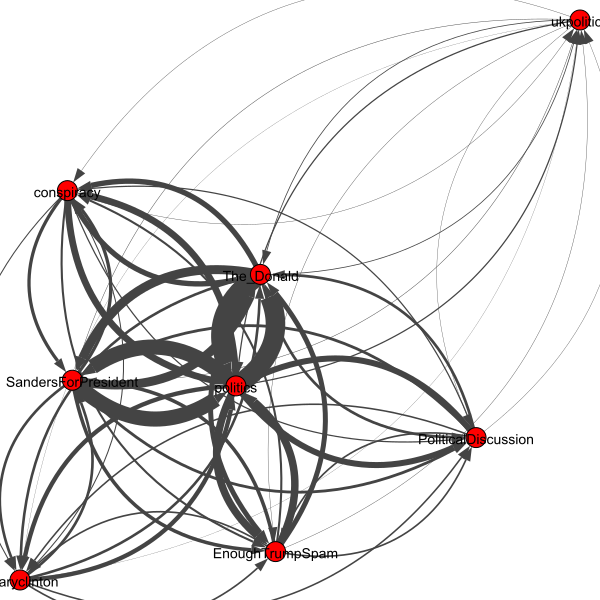

In [29]:
# Add edge weights and node labels.
g_politic_subreddits.es['weight'] = A[A.nonzero()]
g_politic_subreddits.vs['label'] = politic_subreddits
g_politic_subreddits.es['widht'] = A[A.nonzero()] * 0.0009

#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politic_subreddits.layout_fruchterman_reingold(weights = g_politic_subreddits.es['weight'])  
plot(g_politic_subreddits, layout = layout, edge_width = g_politic_subreddits.es['widht'], vertex_label = politic_subreddits)

In [30]:
df_for_total_users = df.set_index("subreddit")

df_politics_adj_percentages = df_politics_adj.copy()
for i in df_politics_adj_percentages.index:
    total_users = len(df_for_total_users.loc[i].users)
    df_politics_adj_percentages.loc[i] = df_politics_adj_percentages.loc[i] / total_users * 100
    #print(i)
    #print(df_politics_adj_percentages.loc[i])

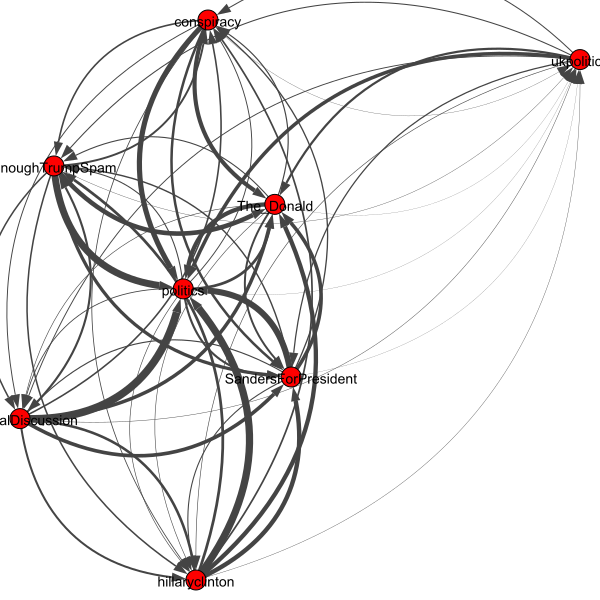

In [31]:
A_perc = df_politics_adj_percentages.values
g_politic_subreddits_2 = Graph().Adjacency((A_perc > 0).tolist())
# Add edge weights and node labels.
g_politic_subreddits_2.es['weight'] = A[A.nonzero()]
g_politic_subreddits_2.vs['label'] = politic_subreddits
g_politic_subreddits_2.es['widht'] = A_perc[A_perc.nonzero()] *0.1

#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politic_subreddits_2.layout_fruchterman_reingold(weights = g_politic_subreddits_2.es['weight'])  
plot(g_politic_subreddits_2, layout = layout, edge_width = g_politic_subreddits_2.es['widht'])

Next step is to try to classify the users ideology. Assuming that every of these subreddits have their own "personality" and ideology, we are going to determine which of them represents better the ideology of every user. For doing that we are going to see in which of the subreddits the user has more score (meaning this that the user opinion is well or bad accepted by the general opinion of the subreddit) and by the number of comments posted in each subreddit (it is normal to thing that people who usually post in an specific subreddit is close to the way of thinking of general people in this subreddit; else this user could be revealed by the score of his comments!) 

Let's obtain first a data frame with all the neccesary data. First we extract a list with all the users which have posted commments in some of these subreddits:

In [32]:
df_total = df.set_index("subreddit")
df_politic_subreddits = df_total.loc[politic_subreddits]

users_list = []
for u in df_politic_subreddits["users"]:
    users_list = users_list + u
    
users_list = list(set(users_list)) #Drop duplicates
len(users_list)

129036

So, we have to classify every user of this list. The idea is to for every user and for each political subreddit determine a value which means the grade of belonging to it; finally we classify the user according to the gratest value. If there is a tie we add this user to both(or more) kinds of user:


Note: Every comment posted in a certain subreddit add +1 point for belonging to it. The score is just added (do not mater if it is positive or negative). With this way of classification we are giving more importance to the score (in case there are great values).

In [83]:
#We use the original data frame in order to get the score and the number of comments in each political subreddit!!
#We are going to classify just a certain number of user (chosen randomly) and extrapolate these results to the vizualizations.
n_users_to_classify = 10000
users_list_s = random.sample(users_list, n_users_to_classify)
df_spark.select("author", "score", "subreddit").write.mode('overwrite').parquet(DATA_DIR + "temp1.parquet")
df_pd2 = pd.read_parquet(DATA_DIR + "temp1.parquet")

In [97]:
#We are going to classify just a certain number of user (chosen randomly) and extrapolate these results to the vizualizations.
n_users_to_classify = 20000
users_list_s = random.sample(users_list, n_users_to_classify)
df_classifying = df_pd2.loc[df_pd2["subreddit"].isin(politic_subreddits) & df_pd2["author"].isin(users_list_s)]

In [99]:
df_classifying.shape #Almost 1 million comments written by 20000 users

(958677, 3)

In [100]:
df_classifier = pd.DataFrame(index = politic_subreddits)
df_classifier["Users_list"] = [list() for x in range(len(df_classifier.index))]

for u in users_list_s:
    subreddit_values = np.zeros(len(politic_subreddits))
    df_user_comments = df_classifying[df_classifying["author"] == u]
    for index, row in df_user_comments.iterrows():
        value = 1
        value = value + row.score
        sreddit_index = politic_subreddits.index(row.subreddit)
        subreddit_values[sreddit_index] = subreddit_values[sreddit_index] + value
    greatest_value = subreddit_values.max()
    for i in range(len(subreddit_values)):         #Neccesary in case there is a tie
        if(greatest_value > 0 and subreddit_values[i] == greatest_value):
            df_classifier["Users_list"].loc[politic_subreddits[i]] = df_classifier["Users_list"].loc[politic_subreddits[i]] + [u] 
    

In [101]:
df_classifier["Number_of_Users_Belonging"] = [len(i) for i in df_classifier["Users_list"]]
df_classifier

,Users_list,Number_of_Users_Belonging
EnoughTrumpSpam,"[Tyrren, WatchRock, EnglishFuckingKing, thenom...",626
PoliticalDiscussion,"[stvey, Skepan, CGinKC, iwanttosoar, DrTryhard...",479
SandersForPresident,"[IrishGh0st91, TurboAbraham, SumthingStupid, T...",2132
The_Donald,"[SecretlyBatgirl, Apopkalypse, Dannyboyayyo, M...",5611
conspiracy,"[JoeQQQ, M1KE_H0NCHO, YeaTired, DamnHippyy, dm...",1091
hillaryclinton,"[motherbear13, FoxFyer, sunshysunshine, Histor...",287
politics,"[aflanryW, sm_frost, 1esserknown, DMS0205, Dia...",8867
ukpolitics,"[AnchezSanchez, theonehundredmod, dibinism, Du...",425


With the classification done, it is time to do the last graph of this kind:

First we need a new adjacency matrix, where the value in the position subreddit1-subreddit2 mean the quantity of users who are from the subreddit1-ideology and who have posted in the subreddit2. (For compute this matrix we use the dataframe `df` obtained at the beginning of this section, which have the list of users who have posted in each subreddit):

In [102]:
df.set_index("subreddit", inplace = True)
df.head(2)

KeyError: 'subreddit'

In [ ]:
df_pol_final = df_politics_adj.copy()
for i in df_pol_final.index:
    for j in df_pol_final.columns:
        if i == j:
            df_pol_final.loc[i][j]=0
        else:
            df_pol_final.loc[i][j] = len(list(set(df_classifier.loc[i]["Users_list"]) & set(df.loc[j]["users"])))

In [ ]:
df_pol_final

In [ ]:
df_politics_adj_classified = df_pol_final
for i in df_politics_adj_classified.index:
    total_users = df_classifier.loc[i]["Number_of_Users_Belonging"]
    df_politics_adj_classified.loc[i] = df_politics_adj_classified.loc[i] / total_users * 100

In [ ]:
df_politics_adj_classified

In [ ]:
A_classified = df_politics_adj_classified.values
g_politic_subreddits_3 = Graph().Adjacency((A_classified > 0).tolist())
# Add edge weights and node labels.
g_politic_subreddits_3.es['weight'] = A_classified[A_classified.nonzero()]
g_politic_subreddits_3.vs['label'] = politic_subreddits
g_politic_subreddits_3.es['widht'] = A_classified[A_classified.nonzero()] *0.1

v_size = [df_classifier.loc[s]["Number_of_Users_Belonging"] * 0.04 for s in politic_subreddits]
g_politic_subreddits_3.es['vertex_size'] = v_size 

#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politic_subreddits_3.layout_fruchterman_reingold(weights = g_politic_subreddits_3.es['weight'])  
plot(g_politic_subreddits_3, layout = layout, edge_width = g_politic_subreddits_3.es['widht'], vertex_size = v_size)

## Classifying users in the range Democrat - Republican by NLP and topic detection

We assume as an hypothesis that the democrats  and the republicans talk about different topics (inside the political topics); since they have different worries and it is usual to criticize differents aspects from the point of view of a democrat and a republican. So they should talk more about certain subtopics; let's try to classify them:

In [ ]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle


seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

First we load the data which we are going to use to train our predictor:

In [ ]:
df_train_data = pd.read_parquet(DATA_DIR + "training_data_cleaned.parquet")
df_train_data.head(3)

This data set is formed by the comments of the republicans, conservatives, liberal and democrats subreddits.

In [ ]:
subreddits_for_training = ["democrats", "Republican", "Liberal", "Conservative"]
republicans_for_training = ["Republican", "Conservative"]
democrats_for_training = ["democrats", "Liberal"]

df_training = (df_train_data.loc[df_pd['subreddit'].isin(subreddits_for_training)])[["subreddit", "body"]]

In [ ]:
df_training["Conservative"] = df_pd['subreddit'].isin(republicans_for_training)

In [ ]:
df_training["Conservative"] = df_training["Conservative"].apply(lambda x: 1 if x == True else 0)

In [ ]:
df_training[df_training["Conservative"]==1].count()

In [ ]:
comments_list = df_training["body"].values
comments_list_class = df_training["Conservative"].values

In [ ]:
comments_list

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(comments_list, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [ ]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

In [ ]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=2, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model.show_topics(num_words=5)

In [ ]:
model.show_topic(1,20)

In [ ]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

In [ ]:
# plot topics
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.save_html(data, 'lda.html')
pyLDAvis.display(data)

In [ ]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [ ]:
# accuracy
from collections import Counter
for book, cluster in book_id.items():
    assignments = list()
    for real,given in zip(comments_list_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")